<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/XGBOOST_models_sentiment_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**THE XGBOOST MODDEL ON TUNISIAN DIALECT**

In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc, accuracy_score
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os
from xgboost import XGBClassifier


# Loading saved vectors 

In [12]:
# loading bow vectors
X_train_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("/content/drive/MyDrive/saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("/content/drive/MyDrive/saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("/content/drive/MyDrive/saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

'''#tfidf-w2v
X_train_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))

'''
y_train = np.load('/content/drive/MyDrive/saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (139367, 144497)
shape of X_test_bow is (59730, 144497)
shape of X_train_tfidf is (139367, 144497)
shape of X_test_tfidf is (59730, 144497)
shape of X_train_avgw2v is (139367, 50)
shape of X_test_avgw2v is (59730, 50)
shape of y_train is (139367,)
shape of y_test is (59730,)


# helper function to plot confusion matrix

In [13]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

# **XGBOOST**
## XGBOOST On BagOfWords Features

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


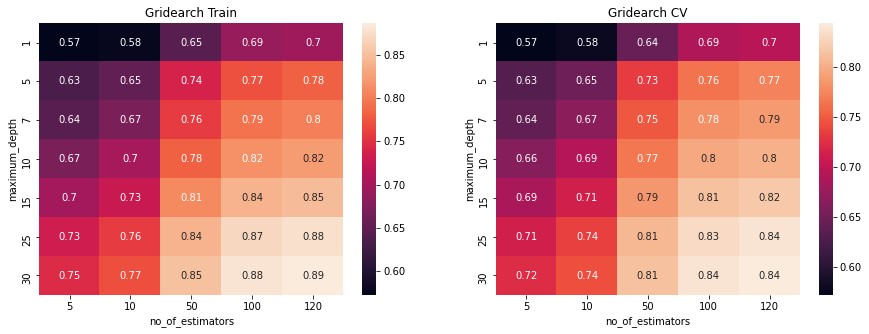

In [4]:
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

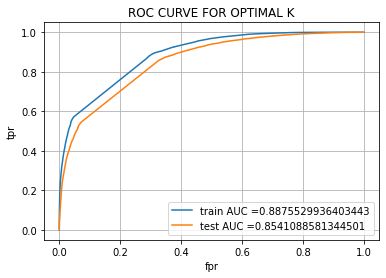

Area under train roc 0.8875529936403443
Area under test roc 0.8541088581344501


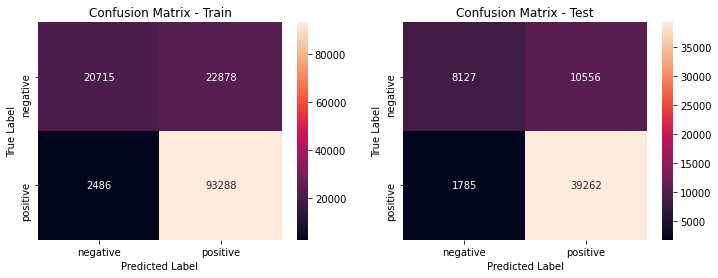


-----classification report on train data on BOW features -----

              precision    recall  f1-score   support

           0       0.89      0.48      0.62     43593
           1       0.80      0.97      0.88     95774

    accuracy                           0.82    139367
   macro avg       0.85      0.72      0.75    139367
weighted avg       0.83      0.82      0.80    139367


-----classification report on validation data on BOW features -----

              precision    recall  f1-score   support

           0       0.82      0.43      0.57     18683
           1       0.79      0.96      0.86     41047

    accuracy                           0.79     59730
   macro avg       0.80      0.70      0.72     59730
weighted avg       0.80      0.79      0.77     59730



In [5]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_train,X_test_bow,y_test)

#classification report on train data
print('\n-----classification report on train data on BOW features -----\n')
print(classification_report(y_train, best_est.predict(X_train_bow)))

#classification report on validation data
print('\n-----classification report on validation data on BOW features -----\n')
print(classification_report(y_test, best_est.predict(X_test_bow)))

# Features Importance

Top 20 features are: 
              coef
bravo    0.013090
ربي      0.004181
tfouh    0.004118
maset    0.003957
يارب     0.003947
bonne    0.003823
masta    0.003769
nul      0.003764
ممتاز    0.003332
اللهم    0.003199
ماسط     0.003115
تافه     0.002926
arnaque  0.002802
super    0.002696
فاشل     0.002644
miboun   0.002628
nulle    0.002593
bara     0.002583
جميل     0.002524
black    0.002429


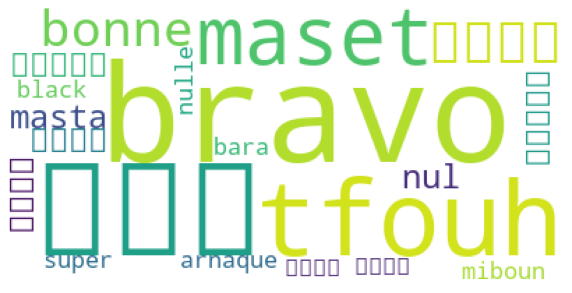

In [6]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = bow_features
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# XGBoost On TFIDF Features


Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


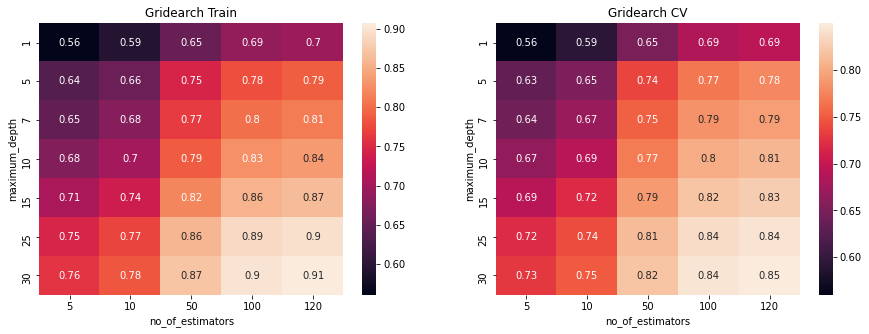

In [7]:
%%time
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfidf,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

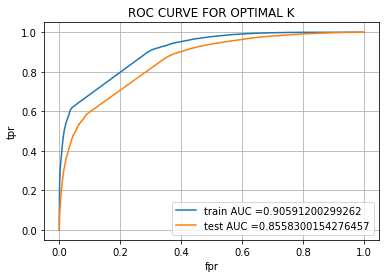

Area under train roc 0.90591200299262
Area under test roc 0.8558300154276457


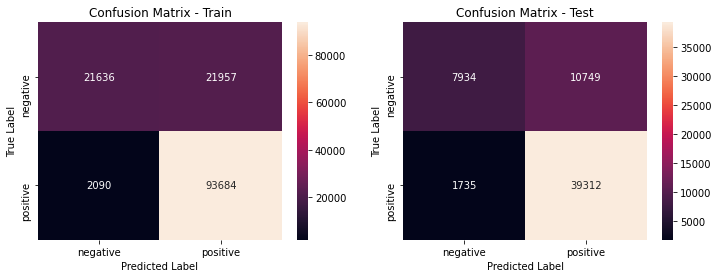


-----classification report on train data on BOW features -----

              precision    recall  f1-score   support

           0       0.91      0.50      0.64     43593
           1       0.81      0.98      0.89     95774

    accuracy                           0.83    139367
   macro avg       0.86      0.74      0.76    139367
weighted avg       0.84      0.83      0.81    139367


-----classification report on validation data on BOW features -----

              precision    recall  f1-score   support

           0       0.82      0.42      0.56     18683
           1       0.79      0.96      0.86     41047

    accuracy                           0.79     59730
   macro avg       0.80      0.69      0.71     59730
weighted avg       0.80      0.79      0.77     59730



In [8]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_train,X_test_tfidf,y_test)

#classification report on train data
print('\n-----classification report on train data on TFIDF features -----\n')
print(classification_report(y_train, best_est.predict(X_train_tfidf)))

#classification report on validation data
print('\n-----classification report on validation data on TFIDF features -----\n')
print(classification_report(y_test, best_est.predict(X_test_tfidf)))

# Features importance

Top 20 features are: 
              coef
maset    0.005077
ماسط     0.004847
يارب     0.004615
tfouh    0.004609
bonne    0.003654
nul      0.003597
ممتاز    0.003441
تافه     0.003426
nik      0.003382
arnaque  0.003133
bravo    0.002916
miboun   0.002896
nulle    0.002802
zok      0.002755
طحان     0.002624
اذا      0.002514
bravoo   0.002498
دق       0.002479
كذابين   0.002475
dislike  0.002449


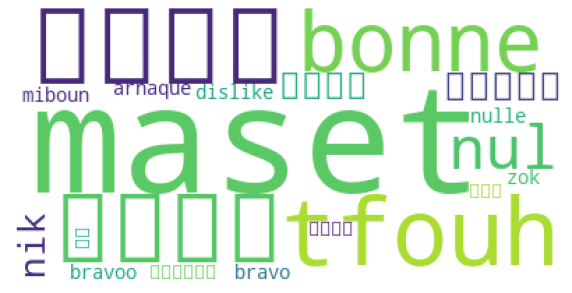

In [9]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = tfidf_features
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# XGBoost On AvgWord2Vec


Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}
CPU times: user 12min 58s, sys: 6.39 s, total: 13min 4s
Wall time: 2h 35min 36s


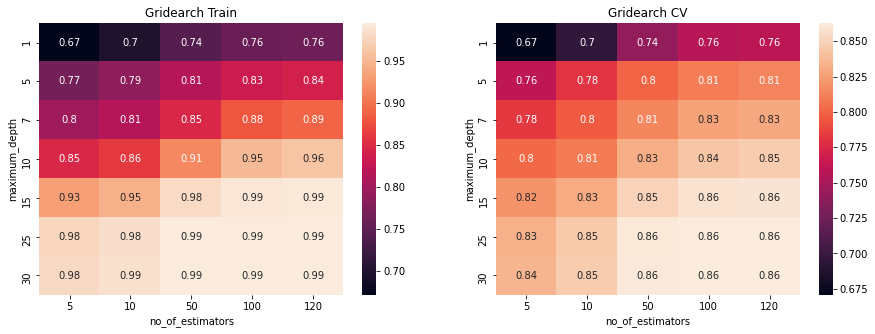

In [14]:
%%time 
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_avgw2v,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

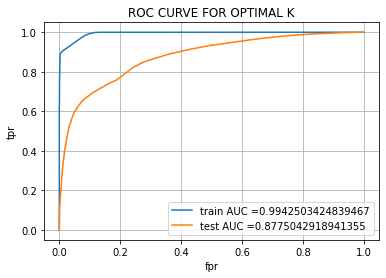

Area under train roc 0.9942503424839467
Area under test roc 0.8775042918941355


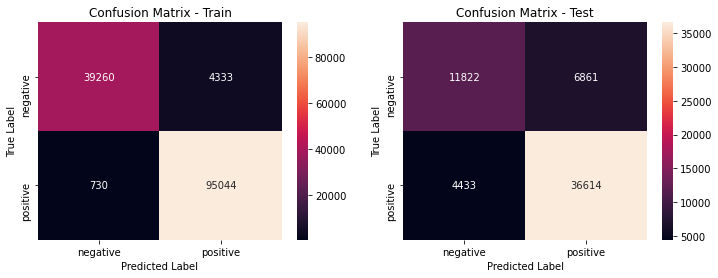


-----classification report on train data on AVG WORD2VEC features -----

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     43593
           1       0.96      0.99      0.97     95774

    accuracy                           0.96    139367
   macro avg       0.97      0.95      0.96    139367
weighted avg       0.96      0.96      0.96    139367


-----classification report on validation data on AVG WORD2VEC features -----

              precision    recall  f1-score   support

           0       0.73      0.63      0.68     18683
           1       0.84      0.89      0.87     41047

    accuracy                           0.81     59730
   macro avg       0.78      0.76      0.77     59730
weighted avg       0.81      0.81      0.81     59730



In [15]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

#classification report on train data
print('\n-----classification report on train data on AVG WORD2VEC features -----\n')
print(classification_report(y_train, best_est.predict(X_train_avgw2v)))

#classification report on validation data
print('\n-----classification report on validation data on AVG WORD2VEC features -----\n')
print(classification_report(y_test, best_est.predict(X_test_avgw2v)))

# **Observations and Conclusions**

In [16]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","Hyperparam-no_of_estimators","Hyperparam-max_Depth","Train AUC", "Test AUC","Train accuracy", "Test accuracy"]
z.add_row(["bow","xgboost",120,30,0.8875529936403443,0.8541088581344501,0.82,0.79])
z.add_row(["tfidf","xgboost",120,30,0.90591200299262,0.8558300154276457,0.83,0.79])
z.add_row(["avgw2v","xgboost",120,30,0.9942503424839467,0.8775042918941355,0.96,0.81])
#z.add_row(["tfidf-w2v","xgboost",120,25,0.9999999953589473, 0.8937122710094956])
print(z)


+--------+-----------+-----------------------------+----------------------+--------------------+--------------------+----------------+---------------+
| Vector | Algorithm | Hyperparam-no_of_estimators | Hyperparam-max_Depth |     Train AUC      |      Test AUC      | Train accuracy | Test accuracy |
+--------+-----------+-----------------------------+----------------------+--------------------+--------------------+----------------+---------------+
|  bow   |  xgboost  |             120             |          30          | 0.8875529936403443 | 0.8541088581344501 |      0.82      |      0.79     |
| tfidf  |  xgboost  |             120             |          30          |  0.90591200299262  | 0.8558300154276457 |      0.83      |      0.79     |
| avgw2v |  xgboost  |             120             |          30          | 0.9942503424839467 | 0.8775042918941355 |      0.96      |      0.81     |
+--------+-----------+-----------------------------+----------------------+-------------------